🔷 1. Pakete & Daten laden

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from workalendar.europe import Germany
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# CSVs laden
base_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/"
df_umsatz = pd.read_csv(base_url + "umsatzdaten_gekuerzt.csv")
df_wetter = pd.read_csv(base_url + "wetter.csv")
df_kiwo = pd.read_csv(base_url + "kiwo.csv")
df_ferien = pd.read_csv("../../data/ferien_sh.csv", parse_dates=["Startdatum", "Enddatum"])

🔷 2. Merge & Feature Engineering

In [12]:
# Datum umwandeln
df_umsatz['Datum'] = pd.to_datetime(df_umsatz['Datum'])
df_wetter['Datum'] = pd.to_datetime(df_wetter['Datum'])
df_kiwo['Datum'] = pd.to_datetime(df_kiwo['Datum'])

from itertools import product

# Alle Datum-Warengruppe-Kombinationen erzeugen
alle_daten = pd.date_range(start="2013-07-01", end="2019-07-31", freq="D")
warengruppen = [1, 2, 3, 4, 5, 6]
voll_kombis = pd.DataFrame(list(product(alle_daten, warengruppen)), columns=["Datum", "Warengruppe"])

# Merge Wetterdaten (nur nach Datum)
df = voll_kombis.merge(df_wetter, on="Datum", how="left")

# Merge KiWo markieren
df_kiwo["KielerWoche"] = 1
df = df.merge(df_kiwo[["Datum", "KielerWoche"]], on="Datum", how="left")
df["KielerWoche"] = df["KielerWoche"].fillna(0).astype(int)

# Merge Umsatz (nach Datum & Warengruppe)
df = df.merge(df_umsatz, on=["Datum", "Warengruppe"], how="left")
df["Umsatz"] = df["Umsatz"].fillna(0)  # Kein Umsatz = 0
df['KielerWoche'] = df['KielerWoche'].fillna(0).astype(int)

# Kalenderfeatures
df['Wochentag'] = df['Datum'].dt.dayofweek
df['Monat'] = df['Datum'].dt.month
df['IstWochenende'] = df['Wochentag'].isin([5, 6]).astype(int)

# Feiertage
cal = Germany(subdivision="SH")
feiertage_set = set()
for jahr in df['Datum'].dt.year.unique():
    feiertage_set.update([d for d, _ in cal.holidays(jahr)])
df['Feiertag'] = df['Datum'].isin(feiertage_set).astype(int)

# Ferienzeit
ferien_tage = set()
for _, row in df_ferien.iterrows():
    ferien_tage.update(pd.date_range(row["Startdatum"], row["Enddatum"]))
df['Ferienzeit'] = df['Datum'].isin(ferien_tage).astype(int)

# Missing values behandeln
df['Wettercode'] = df['Wettercode'].fillna(-1).astype(int)
df['Temperatur'] = df['Temperatur'].fillna(df['Temperatur'].median())
df['Bewoelkung'] = df['Bewoelkung'].fillna(df['Bewoelkung'].median())
df['Windgeschwindigkeit'] = df['Windgeschwindigkeit'].fillna(df['Windgeschwindigkeit'].median())

df["id"] = df.apply(lambda row: int(row["Datum"].strftime("%y%m%d") + str(row["Warengruppe"])), axis=1)

/var/folders/09/wpbg8c7x22x3d_2_ybk_s1g40000gn/T/ipykernel_9336/2484498731.py:36: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['Feiertag'] = df['Datum'].isin(feiertage_set).astype(int)


🔷 3. Split, Train, Evaluate, Export

🔽 Datensplit nach Zeit: Train / Validation / Test

In [13]:
# Zeitbasierter Split des Datensatzes
train = df[(df['Datum'] >= "2013-07-01") & (df['Datum'] <= "2016-12-31")]
val   = df[(df['Datum'] >= "2017-01-01") & (df['Datum'] <= "2017-12-31")]
test  = df[(df['Datum'] >= "2018-01-01") & (df['Datum'] <= "2018-07-31")]

# Optional: kurze Kontrolle
print("Train:", train.shape)
print("Val:", val.shape)
print("Test:", test.shape)

Train: (7680, 14)
Val: (2190, 14)
Test: (1272, 14)


🧠 Trainiere das Modell

In [14]:
from sklearn.ensemble import RandomForestRegressor

features = ['Warengruppe', 'Temperatur', 'Bewoelkung', 'Windgeschwindigkeit',
            'KielerWoche', 'Wochentag', 'Monat', 'IstWochenende', 'Feiertag', 'Ferienzeit']
target = 'Umsatz'

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train[features], train[target])

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


📈 Evaluiere das Modell

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

preds = rf_model.predict(test[features])
rmse = np.sqrt(mean_squared_error(test[target], preds))
r2 = r2_score(test[target], preds)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

RMSE: 56.26
R²: 0.841


<Axes: >

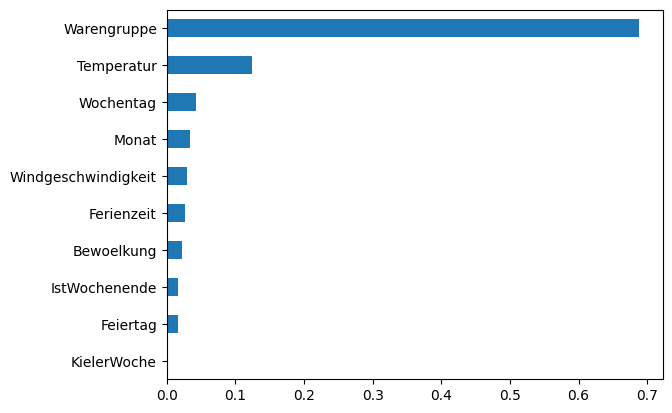

In [16]:
importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind="barh")

In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), params, cv=3)
grid.fit(train[features], train[target])

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'n_estimators': [100, 200]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


📄 CSV für Kaggle vorbereiten

In [18]:
submission = test[['id']].copy()
submission['Umsatz'] = preds
submission.to_csv("submission_randomforest.csv", index=False)
submission.head()

,id,Umsatz
9870,1801011,11.809018
9871,1801012,87.463551
9872,1801013,18.634083
9873,1801014,3.203258
9874,1801015,83.430267


In [20]:
import pandas as pd

df = pd.read_csv("submission_randomforest.csv")
print(df.shape)  # Gibt Zeilen- und Spaltenanzahl aus
print(df.head()) # Zeigt die ersten Zeilen

(1272, 2)
        id     Umsatz
0  1801011  11.809018
1  1801012  87.463551
2  1801013  18.634083
3  1801014   3.203258
4  1801015  83.430267
